In [1]:
import os
from os import listdir
from os.path import isfile, join
from typing import Dict, List
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from hipe_commons.own_helpers import tsv_to_dataframe, get_newsag_df
from hipe_commons.helpers.tsv import parse_tsv, ENTITY_TYPES, HipeDocument
from hipe_commons.stats import describe_dataset

# Create Dataframe for Stats

In [2]:
docs_de_dir = "../data/annotated_retok_autosegment/de/tsv-corrected/"
docs_fr_dir = "../data/annotated_retok_autosegment/fr/tsv-corrected/"

split_de_path = "../data/data_info/train-dev-test_de.csv"
split_fr_path = "../data/data_info/train-dev-test_fr.csv"

docs_de = [f for f in listdir(docs_de_dir) if isfile(join(docs_de_dir, f))]
docs_fr = [f for f in listdir(docs_fr_dir) if isfile(join(docs_fr_dir, f))]

In [3]:
#import information on split
split_de = pd.read_csv(split_de_path).set_index("uid")
split_fr = pd.read_csv(split_fr_path).set_index("uid")

#some articles were wrongly classified as French
luxworts = ["luxwort-1849-06-03-a-i0008", "luxwort-1849-07-15-a-i0002", "luxwort-1850-05-12-a-i0004", "luxwort-1853-11-27-a-i0001", "luxwort-1858-02-26-a-i0009", "luxwort-1858-11-25-a-i0009"]
if luxworts[0] in split_fr.index:
    split_de = pd.concat([split_de, split_fr.loc[luxworts]])
    split_fr = split_fr.drop(luxworts)
    #save changes
    split_de.to_csv(split_de_path)
    split_fr.to_csv(split_fr_path)

    if (luxworts[0] in split_de.index) and (luxworts[0] not in split_fr.index):
        print("Transfer of Luxwort articles completed.")

split_fr.head(2)

,Unnamed: 0,split
uid,,
JDG-1946-11-23-a-i0128,1057,train
IMP-1949-02-04-a-i0155,1039,train


In [4]:
def make_stats_rows(cur_df, annotation_planning):

    mentions = {col: [] for col in ["document_id", "year", "decade", "newspaper", "document_size", "language", "split",
                              "ag_mention", "ag_position", "ag_at_beginning", "ag_at_end",
                              "levenshtein_dist"]}
    
    no_mention = {col: [] for col in ["document_id", "year", "decade", "newspaper", "document_size", "language", "split"]}
    
    doc_id = cur_df["document_id"].values[0]

    if cur_df["news-agency-as-source"].values[0] == "_":
        no_mention["document_id"].append(cur_df["document_id"].values[0])

        year = int(cur_df["date"].values[0][:4])
        no_mention["year"].append(year)
        no_mention["decade"].append(int(year//10 * 10))

        no_mention["newspaper"].append(cur_df["newspaper"].values[0])
        no_mention["document_size"].append(len(cur_df))
        no_mention["language"].append(cur_df["language"].values[0])
        no_mention["split"].append(annotation_planning.loc[doc_id, "split"])
    
    else:
        doc_size = len(cur_df)
        mention_rows = cur_df[cur_df["NE-FINE-LIT"].str.startswith("B-org")]

        for mention_n in list(mention_rows["n"]):
            mention_row = cur_df[cur_df["n"] == mention_n]
            mention_position = mention_n - 6

            mentions["document_id"].append(cur_df["document_id"].values[0])

            year = int(cur_df["date"].values[0][:4])
            mentions["year"].append(year)
            mentions["decade"].append(int(year//10 * 10))

            mentions["newspaper"].append(cur_df["newspaper"].values[0])
            mentions["document_size"].append(doc_size)
            mentions["language"].append(cur_df["language"].values[0])
            mentions["split"].append(annotation_planning.loc[doc_id, "split"])
            mentions["ag_mention"].append(mention_row["NE-FINE-LIT"].values[0].split(".")[-1])
            mentions["ag_position"].append(mention_position)
            mentions["ag_at_beginning"].append(bool(mention_position < 10))
            mentions["ag_at_end"].append(bool(mention_position > (doc_size - 10)))
            mentions["levenshtein_dist"].append(float(mention_row["OCR-INFO"].values[0].split("|")[-1][3:]))

    return pd.DataFrame(mentions), pd.DataFrame(no_mention)


## one row per mention

In [5]:
no_mention_de = pd.DataFrame()
mentions_de = pd.DataFrame()

for doc in docs_de:
    doc_path = join(docs_de_dir, doc)
    cur_df = tsv_to_dataframe(doc_path, keep_comments=True, hipe_format_version="v2")
    mentions_rows, no_mention_row = make_stats_rows(cur_df, split_de)
    mentions_de, no_mention_de = pd.concat([mentions_de, mentions_rows]), pd.concat([no_mention_de, no_mention_row])
    

C:\Users\Lea\AppData\Local\Temp/ipykernel_15276/2334823962.py:8: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  mentions_de, no_mention_de = pd.concat([mentions_de, mentions_rows]), pd.concat([no_mention_de, no_mention_row])


In [6]:
no_mention_fr = pd.DataFrame()
mentions_fr = pd.DataFrame()

for doc in docs_fr:
    doc_path = join(docs_fr_dir, doc)
    cur_df = tsv_to_dataframe(doc_path, keep_comments=True, hipe_format_version="v2")
    mentions_rows, no_mention_row = make_stats_rows(cur_df, split_fr)
    mentions_fr, no_mention_fr = pd.concat([mentions_fr, mentions_rows]), pd.concat([no_mention_fr, no_mention_row])
    

C:\Users\Lea\AppData\Local\Temp/ipykernel_15276/1013314241.py:8: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  mentions_fr, no_mention_fr = pd.concat([mentions_fr, mentions_rows]), pd.concat([no_mention_fr, no_mention_row])


In [7]:
#decade column to integer
no_mention_de["decade"] = no_mention_de["decade"].astype(int)
no_mention_fr["decade"] = no_mention_fr["decade"].astype(int)
mentions_fr["decade"] = mentions_fr["decade"].astype(int)
mentions_de["decade"] = mentions_de["decade"].astype(int)

#new column: agency_in_middle
mentions_fr["ag_in_middle"] = mentions_fr["ag_at_end"] + mentions_fr["ag_at_beginning"]
mentions_fr["ag_in_middle"] = mentions_fr["ag_in_middle"].apply(lambda row: 0 if row > 0 else 1)
mentions_de["ag_in_middle"] = mentions_de["ag_at_end"] + mentions_de["ag_at_beginning"]
mentions_de["ag_in_middle"] = mentions_de["ag_in_middle"].apply(lambda row: 0 if row > 0 else 1)

In [8]:
no_mention_de.head()

,document_id,year,decade,newspaper,document_size,language,split
0,buergerbeamten-1902-07-15-a-i0007,1902.0,1900,buergerbeamten,2140.0,de,train
0,buergerbeamten-1904-06-02-a-i0003,1904.0,1900,buergerbeamten,278.0,de,train
0,buergerbeamten-1904-06-14-a-i0011,1904.0,1900,buergerbeamten,859.0,de,train
0,buergerbeamten-1905-05-13-a-i0009,1905.0,1900,buergerbeamten,59.0,de,train
0,buergerbeamten-1907-01-24-a-i0008,1907.0,1900,buergerbeamten,1550.0,de,train


In [9]:
mentions_de.head()

,document_id,year,decade,newspaper,document_size,language,split,ag_mention,ag_position,ag_at_beginning,ag_at_end,levenshtein_dist,ag_in_middle
0,buergerbeamten-1910-06-18-a-i0009,1910.0,1910,buergerbeamten,487.0,de,train,Wolff,423.0,0.0,0.0,0.15,1
0,buergerbeamten-1915-12-14-a-i0006,1915.0,1910,buergerbeamten,65.0,de,train,Havas,6.0,1.0,0.0,0.00,0
1,buergerbeamten-1915-12-14-a-i0006,1915.0,1910,buergerbeamten,65.0,de,train,Havas,60.0,0.0,1.0,0.00,0
0,DTT-1943-01-13-a-i0005,1943.0,1940,DTT,1483.0,de,train,UP-UPI,61.0,0.0,0.0,0.00,1
1,DTT-1943-01-13-a-i0005,1943.0,1940,DTT,1483.0,de,train,Extel,537.0,0.0,0.0,0.00,1


In [10]:
mentions_de_ag_cols = pd.get_dummies(mentions_de, prefix="", prefix_sep="", columns=["ag_mention"])
mentions_fr_ag_cols = pd.get_dummies(mentions_fr, prefix="", prefix_sep="", columns=["ag_mention"])

mentions_fr_ag_cols.head(1)

,document_id,year,decade,newspaper,document_size,language,split,ag_position,ag_at_beginning,ag_at_end,...,Havas,Kipa,Reuters,Stefani,TASS,UP-UPI,Wolff,Xinhua,ag,unk
0,avenirgdl-1869-09-20-a-i0002,1869.0,1860,avenirgdl,144.0,fr,train,38.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0


## one row per article

In [11]:
articles_de = mentions_de.groupby(["document_id", "year", "decade", "newspaper", "document_size", 
                                              "language"]).agg(list).reset_index()
articles_fr = mentions_fr.groupby(["document_id", "year", "decade", "newspaper", "document_size", 
                                              "language"]).agg(list).reset_index()

In [12]:
articles_de.head()

,document_id,year,decade,newspaper,document_size,language,split,ag_mention,ag_position,ag_at_beginning,ag_at_end,levenshtein_dist,ag_in_middle
0,DTT-1943-01-13-a-i0005,1943.0,1940,DTT,1483.0,de,"[train, train, train, train, train, train]","[UP-UPI, Extel, DNB, Extel, Extel, Extel]","[61.0, 537.0, 625.0, 867.0, 1462.0, 1553.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.25, 0.0, 0.12]","[1, 1, 1, 1, 1, 0]"
1,DTT-1943-06-05-a-i0036,1943.0,1940,DTT,1811.0,de,"[train, train, train, train, train, train]","[Extel, UP-UPI, ag, DNB, Reuters, Extel]","[203.0, 382.0, 656.0, 730.0, 898.0, 1134.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.25, 0.0, 0.5, 0.0]","[1, 1, 1, 1, 1, 1]"
2,DTT-1943-07-20-a-i0033,1943.0,1940,DTT,552.0,de,"[train, train, train]","[UP-UPI, Extel, UP-UPI]","[79.0, 253.0, 474.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[1, 1, 1]"
3,DTT-1943-09-30-a-i0009,1943.0,1940,DTT,1225.0,de,"[test, test, test, test, test, test, test, tes...","[UP-UPI, Extel, DNB, ag, Reuters, Reuters, DNB...","[25.0, 531.0, 621.0, 780.0, 859.0, 973.0, 1068...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.33, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0]"
4,DTT-1945-08-09-a-i0008,1945.0,1940,DTT,303.0,de,"[dev, dev]","[Extel, UP-UPI]","[150.0, 241.0]","[0.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]","[1, 1]"


In [13]:
articles_de_ag_cols = mentions_de_ag_cols.groupby(["document_id", "year", "decade", "newspaper", "document_size", 
                                              "language"]).agg(sum).reset_index().drop("ag_position", axis=1)
articles_fr_ag_cols = mentions_fr_ag_cols.groupby(["document_id", "year", "decade", "newspaper", "document_size", 
                                              "language"]).agg(sum).reset_index().drop("ag_position", axis=1)

articles_de_ag_cols.head()

C:\Users\Lea\AppData\Local\Temp/ipykernel_15276/502139093.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  articles_de_ag_cols = mentions_de_ag_cols.groupby(["document_id", "year", "decade", "newspaper", "document_size",
C:\Users\Lea\AppData\Local\Temp/ipykernel_15276/502139093.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  articles_fr_ag_cols = mentions_fr_ag_cols.groupby(["document_id", "year", "decade", "newspaper", "document_size",


,document_id,year,decade,newspaper,document_size,language,ag_at_beginning,ag_at_end,levenshtein_dist,ag_in_middle,...,Extel,Havas,Kipa,Reuters,SPK-SMP,TASS,UP-UPI,Wolff,ag,unk
0,DTT-1943-01-13-a-i0005,1943.0,1940,DTT,1483.0,de,0.0,1.0,0.37,5,...,4,0,0,0,0,0,1,0,0,0
1,DTT-1943-06-05-a-i0036,1943.0,1940,DTT,1811.0,de,0.0,0.0,0.75,6,...,2,0,0,1,0,0,1,0,1,0
2,DTT-1943-07-20-a-i0033,1943.0,1940,DTT,552.0,de,0.0,0.0,0.00,3,...,1,0,0,0,0,0,2,0,0,0
3,DTT-1943-09-30-a-i0009,1943.0,1940,DTT,1225.0,de,0.0,1.0,0.33,9,...,1,0,0,3,0,0,1,0,2,0
4,DTT-1945-08-09-a-i0008,1945.0,1940,DTT,303.0,de,0.0,0.0,0.00,2,...,1,0,0,0,0,0,1,0,0,0


# Stats

## Agency distributions

In [14]:
decades = list(range(1840, 2000, 10))
print(decades)

[1840, 1850, 1860, 1870, 1880, 1890, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990]


In [15]:
ag_fr_index = list(mentions_fr_ag_cols.columns).index("AFP")
ag_fr = list(mentions_fr_ag_cols.columns[ag_fr_index:])

ag_de_index = list(mentions_de_ag_cols.columns).index("AFP")
ag_de = list(mentions_de_ag_cols.columns[ag_de_index:])

print(f"Agencies in German sample: {ag_de}\nAgencies in French sample: {ag_fr}")
print(f"not in German (but in French) sample: {set(ag_fr).difference(set(ag_de))}\nnot in French (but in German) sample: {set(ag_de).difference(set(ag_fr))}")

Agencies in German sample: ['AFP', 'AP', 'ATS-SDA', 'Belga', 'DDP-DAPD', 'DNB', 'DPA', 'Europapress', 'Extel', 'Havas', 'Kipa', 'Reuters', 'SPK-SMP', 'TASS', 'UP-UPI', 'Wolff', 'ag', 'unk']
Agencies in French sample: ['AFP', 'ANSA', 'AP', 'APA', 'ATS-SDA', 'Belga', 'CTK', 'DNB', 'DPA', 'Domei', 'Extel', 'Havas', 'Kipa', 'Reuters', 'Stefani', 'TASS', 'UP-UPI', 'Wolff', 'Xinhua', 'ag', 'unk']
not in German (but in French) sample: {'ANSA', 'Stefani', 'Domei', 'APA', 'Xinhua', 'CTK'}
not in French (but in German) sample: {'SPK-SMP', 'DDP-DAPD', 'Europapress'}


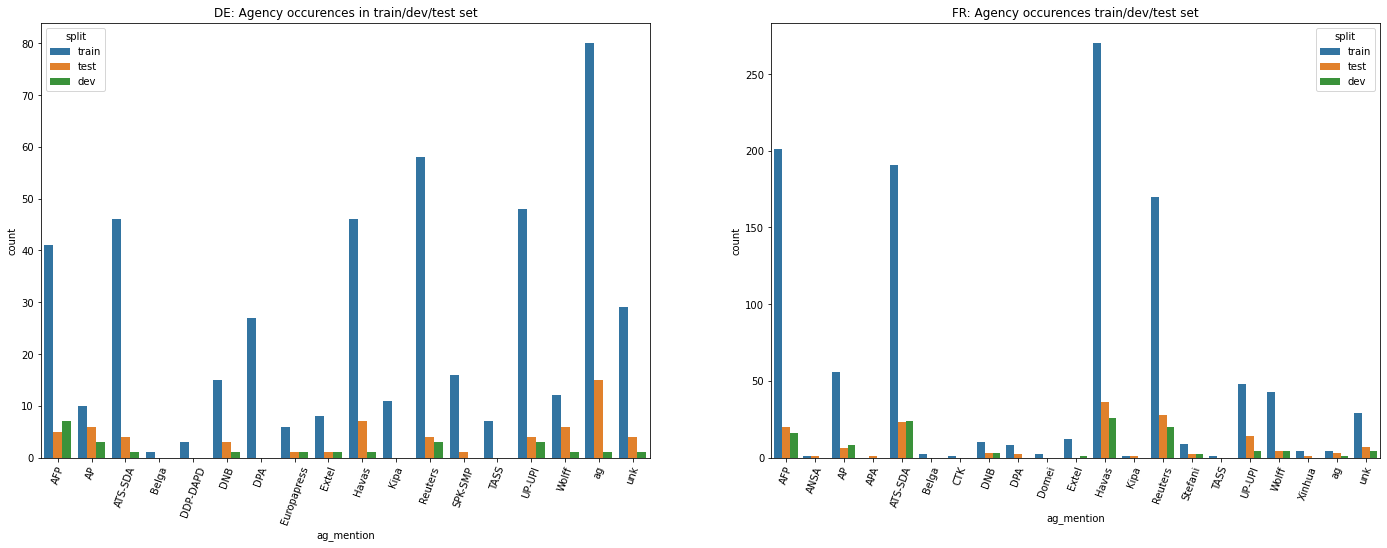

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(24)
fig.set_figheight(8)

#plots
sns.countplot(x = "ag_mention", hue = "split", data = mentions_de, order=sorted(ag_de), ax=ax1)
sns.countplot(x = "ag_mention", hue = "split", data = mentions_fr, order=sorted(ag_fr), ax=ax2)

#layout
ax1.tick_params(axis="x", rotation=70)
ax2.tick_params(axis="x", rotation=70)
ax1.set_title("DE: Agency occurences in train/dev/test set")
ax2.set_title("FR: Agency occurences train/dev/test set")

plt.show()

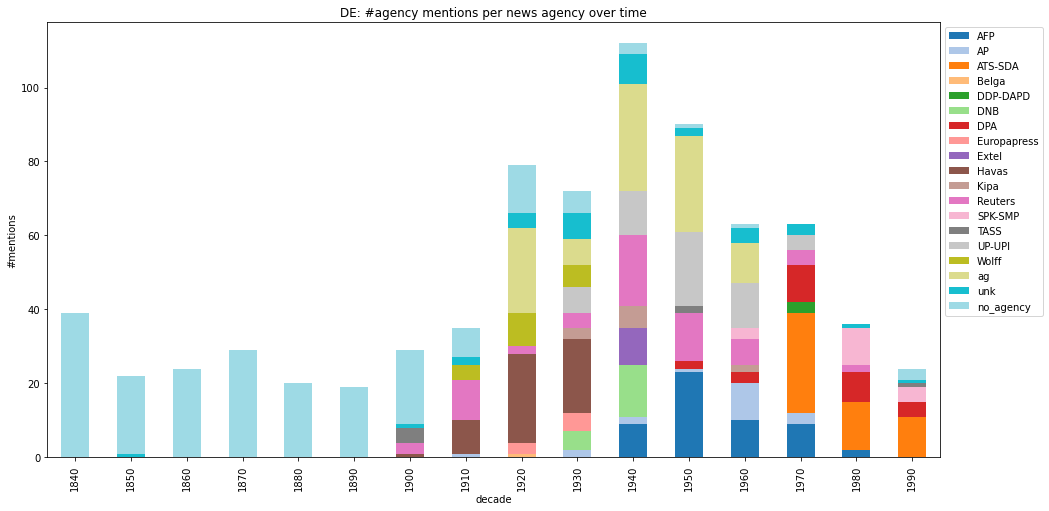

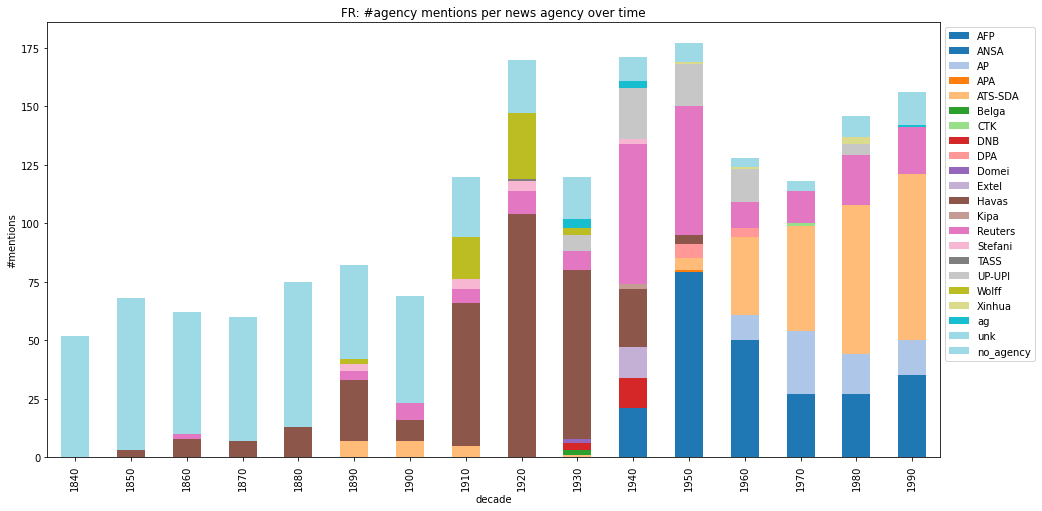

In [17]:
#German
na_per_decade_de = pd.pivot_table(mentions_de, index="decade", columns="ag_mention", values="document_id", aggfunc="count")
no_agency_per_decade_de = no_mention_de.groupby(by="decade")[["document_id"]].count().rename(columns={"document_id": "no_agency"})
na_per_decade_de = na_per_decade_de.join(no_agency_per_decade_de, how="outer")

na_per_decade_de.plot(kind="bar", stacked=True, figsize=(16,8), ylabel="#mentions", title="DE: #agency mentions per news agency over time", colormap='tab20')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")

#French
na_per_decade_fr = pd.pivot_table(mentions_fr, index="decade", columns="ag_mention", values="document_id", aggfunc="count")
no_agency_per_decade_fr = no_mention_fr.groupby(by="decade")[["document_id"]].count().rename(columns={"document_id": "no_agency"})
na_per_decade_fr = na_per_decade_fr.join(no_agency_per_decade_fr, how="outer")

na_per_decade_fr.plot(kind="bar", stacked=True, figsize=(16,8), ylabel="#mentions", title="FR: #agency mentions per news agency over time", colormap='tab20')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")

#Plot
plt.show()

## Distribution of Articles

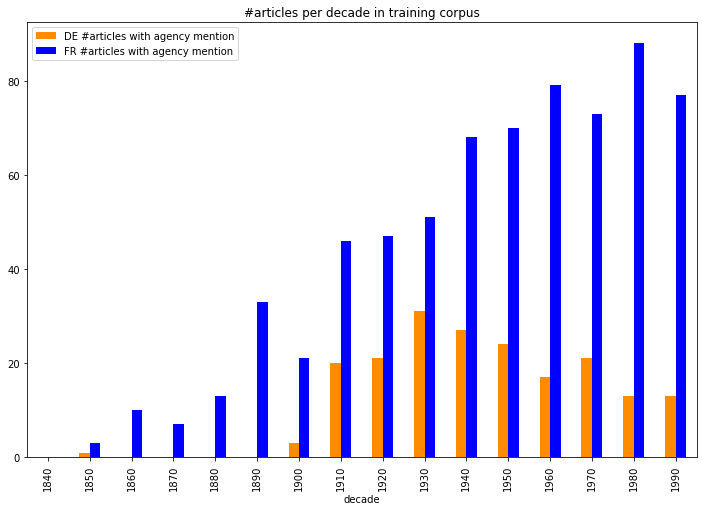

In [18]:
dec_count = articles_de.groupby("decade")[["document_id"]].count().rename(columns={"document_id": "DE #articles with agency mention"})
dec_count = dec_count.join(no_mention_de.groupby("decade")[["document_id"]].count().rename(columns={"document_id": "DE #articles no agency mention"}), how="outer")
dec_count = dec_count.join(articles_fr.groupby("decade")[["document_id"]].count().rename(columns={"document_id": "FR #articles with agency mention"}), how="outer")
dec_count = dec_count.join(no_mention_fr.groupby("decade")[["document_id"]].count().rename(columns={"document_id": "FR #articles no agency mention"}), how="outer")

dec_count.plot.bar(y=["DE #articles with agency mention", "FR #articles with agency mention"], figsize=(12,8), color=["darkorange", "blue"])
plt.title("#articles per decade in training corpus")
plt.show()

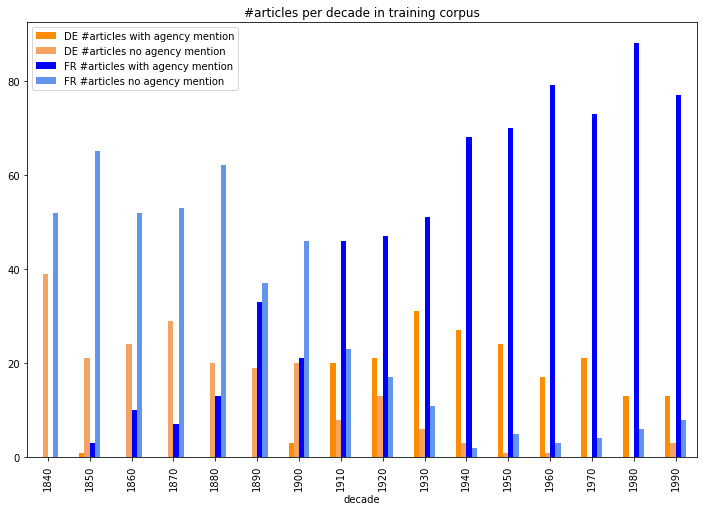

In [19]:
dec_count.plot.bar(figsize=(12,8), color=["darkorange", "sandybrown", "blue", "cornflowerblue"])
plt.title("#articles per decade in training corpus")
plt.show()

## Several Mentions per Article

In [20]:
articles_fr["number_ag_mentions"] = articles_fr["ag_mention"].apply(len)
articles_de["number_ag_mentions"] = articles_de["ag_mention"].apply(len)

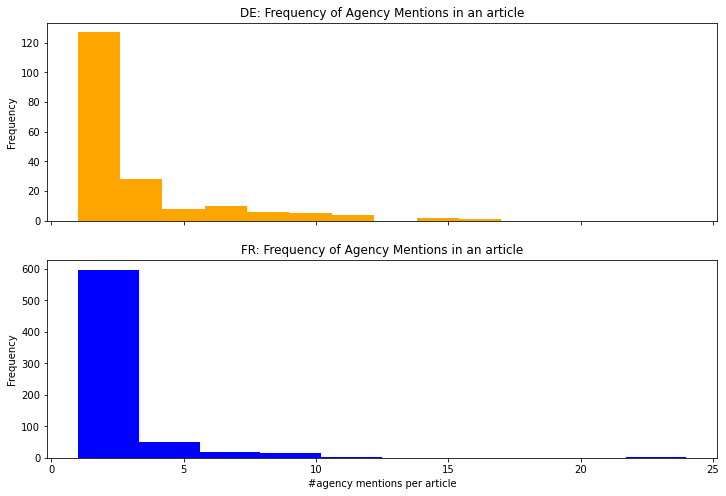

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(12,8))
articles_de["number_ag_mentions"].plot.hist(ax=ax1, title="DE: Frequency of Agency Mentions in an article", color="orange")
articles_fr["number_ag_mentions"].plot.hist(ax=ax2, title="FR: Frequency of Agency Mentions in an article", color="blue")
ax2.set_xlabel("#agency mentions per article")
plt.show()

## Noisy OCR

In [22]:
mentions_fr["noisy_OCR"] = mentions_fr["levenshtein_dist"] > 0
mentions_de["noisy_OCR"] = mentions_de["levenshtein_dist"] > 0
mentions_de.head()

,document_id,year,decade,newspaper,document_size,language,split,ag_mention,ag_position,ag_at_beginning,ag_at_end,levenshtein_dist,ag_in_middle,noisy_OCR
0,buergerbeamten-1910-06-18-a-i0009,1910.0,1910,buergerbeamten,487.0,de,train,Wolff,423.0,0.0,0.0,0.15,1,True
0,buergerbeamten-1915-12-14-a-i0006,1915.0,1910,buergerbeamten,65.0,de,train,Havas,6.0,1.0,0.0,0.00,0,False
1,buergerbeamten-1915-12-14-a-i0006,1915.0,1910,buergerbeamten,65.0,de,train,Havas,60.0,0.0,1.0,0.00,0,False
0,DTT-1943-01-13-a-i0005,1943.0,1940,DTT,1483.0,de,train,UP-UPI,61.0,0.0,0.0,0.00,1,False
1,DTT-1943-01-13-a-i0005,1943.0,1940,DTT,1483.0,de,train,Extel,537.0,0.0,0.0,0.00,1,False


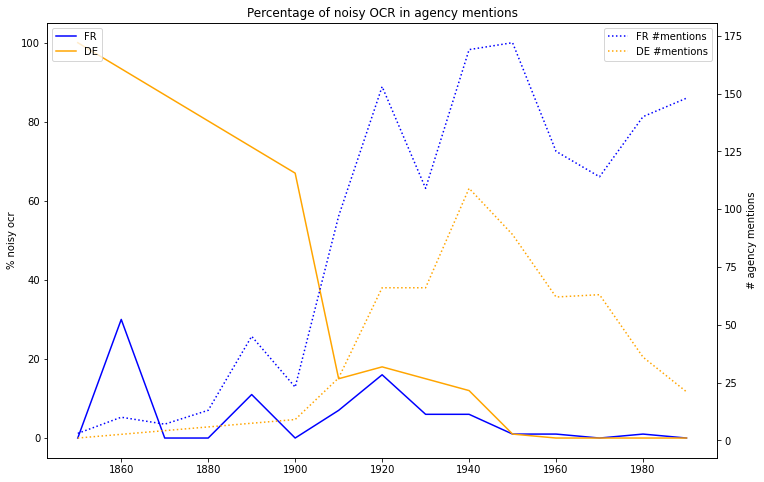

In [23]:
noisy_ocr_de = mentions_de.groupby("decade")["noisy_OCR"].agg(["count", "sum"]).rename(columns={"count": "total", "sum": "noisy_ocr"})
noisy_ocr_de["noisy_ocr_perc"] = noisy_ocr_de.apply(lambda row: round(row["noisy_ocr"] / row["total"] * 100), axis=1)

noisy_ocr_fr = mentions_fr.groupby("decade")["noisy_OCR"].agg(["count", "sum"]).rename(columns={"count": "total", "sum": "noisy_ocr"})
noisy_ocr_fr["noisy_ocr_perc"] = noisy_ocr_fr.apply(lambda row: round(row["noisy_ocr"] / row["total"] * 100), axis=1)

fig, ax1 = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(12)
ax1.plot(noisy_ocr_fr["noisy_ocr_perc"], label="FR", color="blue")
ax1.plot(noisy_ocr_de["noisy_ocr_perc"], label="DE", color="orange")

ax2 = ax1.twinx()
ax2.plot(noisy_ocr_fr["total"], label="FR #mentions", color="blue", linestyle="dotted")
ax2.plot(noisy_ocr_de["total"], label="DE #mentions", color="orange", linestyle="dotted")

plt.title("Percentage of noisy OCR in agency mentions")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
ax1.set_ylabel("% noisy ocr")
ax2.set_ylabel("# agency mentions")
plt.show()

### check discarded files

In [24]:
from collections import Counter
log_path = "../data/logs/"

with open(log_path + "discarded_de.txt", "r") as f:
    discarded_de = [f.strip() for f in f.readlines()]

with open(log_path + "discarded_fr.txt", "r") as f:
    discarded_fr = [f.strip() for f in f.readlines()]

print(f"#discarded in DE: {len(discarded_de)}")
print(f"#discarded in FR: {len(discarded_fr)}")


#discarded in DE: 15
#discarded in FR: 65


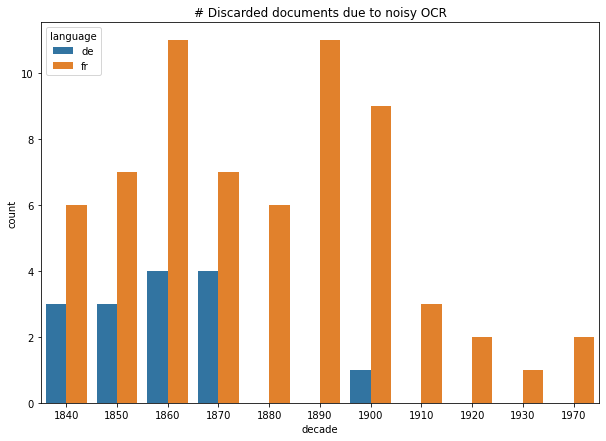

In [25]:
discarded_de_years = sorted([entry.split('-')[1] for entry in discarded_de])
discarded_fr_years = sorted([entry.split('-')[1] for entry in discarded_fr])
discarded_df = pd.concat([pd.DataFrame({"year": discarded_de_years, "language": "de"}), pd.DataFrame({"year": discarded_fr_years, "language": "fr"})])
discarded_df["decade"] = discarded_df["year"].apply(lambda x: int(x) //10 * 10)

countplt, ax = plt.subplots(figsize = (10,7))
sns.countplot(data=discarded_df, x="decade", hue="language")
plt.title("# Discarded documents due to noisy OCR")
plt.show()

## unk

In [26]:
unk_de = get_newsag_df("unk", docs_de_dir, docs_de)
unk_fr = get_newsag_df("unk", docs_fr_dir, docs_fr)

In [27]:
unk_de["name"].value_counts()

Telunion                                                 3
ADN                                                      2
Conti                                                    2
Tsch . P . V .                                           2
ATA                                                      2
Agence dAnatoiie                                         1
KNA                                                      1
Pm                                                       1
Agence Fournier                                          1
Petersburger Telegr . - Agentur .                        1
Petersburger Telegraphen - Agentur                       1
kaiserlich - lönigliche Wiener Korrespondenz - Bureau    1
Kori - esp . Bureau                                      1
rma                                                      1
Bernama News Agency                                      1
A . S .                                                  1
Interim                                                 

In [28]:
unk_fr["name"].value_counts()

Ofi                     3
B . C . H .             2
P . T . S .             2
Keystone                2
Red                     2
Press Association       2
C . N . B .             2
APF                     1
Dalziel                 1
APP                     1
ATQ                     1
CPS                     1
NDB                     1
OFI                     1
patriarche              1
I . P . S .             1
R . K .                 1
L . Bo                  1
Interinf                1
M . de B .              1
C . P .                 1
Chek lau                1
Pat                     1
Temps                   1
Daniel                  1
A . TE . P .            1
Telepress               1
B . P . Tchèque         1
Correspondenzbureaiv    1
R . F . P .             1
O . P . A .             1
Chekiai                 1
Name: name, dtype: int64

## Position of Agency Mentions

In [29]:
sum_mentions_de = len(mentions_de)
sum_mentions_fr = len(mentions_fr)

print("Statistics per Agency Mention")
print(f"DE: {round(sum(mentions_de['ag_at_beginning'])/sum_mentions_de*100)}% agency mentions at beginning, {round(sum(mentions_de['ag_in_middle'])/sum_mentions_de*100)}% in the middle, \
{round(sum(mentions_de['ag_at_end'])/sum_mentions_de*100)}% at end")
print(f"FR: {round(sum(mentions_fr['ag_at_beginning'])/sum_mentions_fr*100)}% agency mentions at beginning, {round(sum(mentions_fr['ag_in_middle'])/sum_mentions_fr*100)}% in the middle, \
{round(sum(mentions_fr['ag_at_end'])/sum_mentions_fr*100)}% at end")

Statistics per Agency Mention
DE: 4% agency mentions at beginning, 86% in the middle, 10% at end
FR: 3% agency mentions at beginning, 74% in the middle, 23% at end


In [30]:
sum_articles_de = len(articles_de)
sum_articles_fr = len(articles_fr)

lambda_exp = lambda row: 1 if sum(row) > 0 else 0

print("Statistics per Article (several agency mentions in one article possible)")
print(f"DE: {round(sum(articles_de['ag_at_beginning'].apply(lambda_exp))/sum_articles_de*100)}% of articles have agency mentions at beginning, \
{round(sum(articles_de['ag_in_middle'].apply(lambda_exp))/sum_articles_de*100)}% in the middle, \
{round(sum(articles_de['ag_at_end'].apply(lambda_exp))/sum_articles_de*100)}% at end")
print(f"FR: {round(sum(articles_fr['ag_at_beginning'].apply(lambda_exp))/sum_articles_fr*100)}% of articles have agency mentions at beginning, \
{round(sum(articles_fr['ag_in_middle'].apply(lambda_exp))/sum_articles_fr*100)}% in the middle, \
{round(sum(articles_fr['ag_at_end'].apply(lambda_exp))/sum_articles_fr*100)}% at end")

Statistics per Article (several agency mentions in one article possible)
DE: 12% of articles have agency mentions at beginning, 88% in the middle, 22% at end
FR: 6% of articles have agency mentions at beginning, 70% in the middle, 37% at end


## Working with Release Dataset

In [31]:
RELEASE_VERSION = "1"
newsag_data_path = f"../data/release/{RELEASE_VERSION}/"

In [32]:
# DE
newsag_train_de_path = os.path.join(newsag_data_path, f"de/newsagency-data-{RELEASE_VERSION}-train-de.tsv")
newsag_dev_de_path = os.path.join(newsag_data_path, f"de/newsagency-data-{RELEASE_VERSION}-dev-de.tsv")
newsag_test_de_path = os.path.join(newsag_data_path, f"de/newsagency-data-{RELEASE_VERSION}-test-de.tsv")

# FR
newsag_train_fr_path = os.path.join(newsag_data_path, f"fr/newsagency-data-{RELEASE_VERSION}-train-fr.tsv")
newsag_dev_fr_path = os.path.join(newsag_data_path, f"fr/newsagency-data-{RELEASE_VERSION}-dev-fr.tsv")
newsag_test_fr_path = os.path.join(newsag_data_path, f"fr/newsagency-data-{RELEASE_VERSION}-test-fr.tsv")

In [33]:
# parse the TSV into a list of `HipeDocument` objects
newsag_train_de_docs = parse_tsv(file_path=newsag_train_de_path)

In [34]:
# print some basic stats for the TSV dataset 
print(describe_dataset(documents=newsag_train_de_docs))


Path of the TSV file: ../data/release/1/de/newsagency-data-1-train-de.tsv 
Number of documents: 296 
Number of entities: {'coarse_lit': 427, 'fine_lit': 427} 
Number of tokens: 221604 
Entity breakdown by type: coarse_lit
+------+---------+
|      |   count |
+======+=========+
| org  |     407 |
+------+---------+
| pers |      20 |
+------+---------+
fine_lit
+---------------------------------+---------+
|                                 |   count |
+=================================+=========+
| org.ent.pressagency.AFP         |      33 |
+---------------------------------+---------+
| org.ent.pressagency.AP          |      10 |
+---------------------------------+---------+
| org.ent.pressagency.ATS         |      38 |
+---------------------------------+---------+
| org.ent.pressagency.Belga       |       1 |
+---------------------------------+---------+
| org.ent.pressagency.DDP         |       3 |
+---------------------------------+---------+
| org.ent.pressagency.DNB         |  

In [35]:
for i in range(4):
    print(newsag_train_de_docs[i].metadata)

{'global.columns': 'TOKEN NE-COARSE-LIT NE-COARSE-METO NE-FINE-LIT NE-FINE-METO NE-FINE-COMP NE-NESTED NEL-LIT NEL-METO RENDER SEG OCR-INFO MISC', 'language': 'de', 'newspaper': 'DTT', 'date': '1943-01-13', 'document_id': 'DTT-1943-01-13-a-i0005', 'news-agency-as-source': 'Q493845, unk, Q1205856', 'segment_iiif_link': 'https://impresso-project.ch/api/proxy/iiif/DTT-1943-01-13-a-p0001/2679,5333,834,65/full/0/default.jpg'}
{'language': 'de', 'newspaper': 'DTT', 'date': '1943-06-05', 'document_id': 'DTT-1943-06-05-a-i0036', 'news-agency-as-source': 'Q493845, unk, Q130879, Q1205856', 'segment_iiif_link': 'https://impresso-project.ch/api/proxy/iiif/DTT-1943-06-05-a-p0011/2770,2185,593,64/full/0/default.jpg'}
{'language': 'de', 'newspaper': 'DTT', 'date': '1943-07-20', 'document_id': 'DTT-1943-07-20-a-i0033', 'news-agency-as-source': 'Q493845, unk', 'segment_iiif_link': 'https://impresso-project.ch/api/proxy/iiif/DTT-1943-07-20-a-p0001/2599,2754,709,66/full/0/default.jpg'}
{'language': 'de',

In [36]:
# slightly modified version of the original function
def count_entities(docs: List[HipeDocument], exclude_from_NIL: List[str] = []) -> Dict:

    counts = {}
    
    for e_type in ENTITY_TYPES:
        for doc in docs:
            if e_type in doc.entities:
                if e_type not in counts:
                    counts[e_type] = 0
                counts[e_type] += len(doc.entities[e_type])
                
    # count the NIL entities
    # TODO: for ajmc, exclude from counts those that are not
    # supposed to be linked as per participation guidelines
                
    nil_entities_count = 0
    wikidata_linked_count = 0
    nonlinked_count = 0
    noisy_entities_count = 0
    for doc in docs:
        
        if not 'coarse_lit' in doc.entities:
            continue
        
        for entity in doc.entities['coarse_lit']:
            
            if entity.wikidata_id is not None:
                if entity.wikidata_id == "NIL":
                    
                    if entity.tag in exclude_from_NIL:
                        nonlinked_count += 1
                    else:
                        nil_entities_count += 1
                
                elif entity.wikidata_id != "NIL":
                    wikidata_linked_count += 1
            else:
                nonlinked_count += 1
                
            #if entity.LED and entity.LED > 0:
            #    noisy_entities_count += 1
                
    counts['nil'] = nil_entities_count
    counts['wikidata_link'] = wikidata_linked_count
    counts['non_linked'] = nonlinked_count
    counts['noisy'] = noisy_entities_count
    return counts



def compute_dataset_stats(**kwargs):
    if "file_path" in kwargs:
        path = kwargs['file_path']
        docs = parse_tsv(file_path=path)
    elif "file_url" in kwargs:
        path = kwargs['file_url']
        docs = parse_tsv(file_url=path)
    elif "documents" in kwargs:
        docs = kwargs['documents']
        path = docs[0].path
    else:
        raise
        
    total_n_tokens = sum([
        doc.n_tokens
        for doc in docs
    ])
    
    entity_counts = count_entities(docs, exclude_from_NIL=['time'])
        
    data = {
        "n_docs": len(docs),
        "total_n_tokens": total_n_tokens,
        "n_mentions": entity_counts['coarse_lit'],
        "n_nested": entity_counts['nested'] if 'nested' in entity_counts else None,
        "n_nil": entity_counts['nil'],
        "n_wikidata_link": entity_counts['wikidata_link'],
        "n_linkable_mentions": entity_counts['coarse_lit'] - entity_counts['non_linked'],
        "n_non_linked": entity_counts['non_linked'],
        "n_noisy": entity_counts['noisy']
    }
    
    return pd.DataFrame([data])

In [37]:
dataset_df = compute_dataset_stats(file_path=newsag_train_de_path)

In [38]:
dataset_df

,n_docs,total_n_tokens,n_mentions,n_nested,n_nil,n_wikidata_link,n_linkable_mentions,n_non_linked,n_noisy
0,296,221604,427,None,0,290,290,137,0
